In [11]:

import numpy as np
from skimage import exposure
from skimage.filters import unsharp_mask, threshold_multiotsu, sato, hessian
from skimage.color import rgb2hsv, hsv2rgb

def image_process(image,
                  hist_norm_perc_low=10, hist_norm_perc_upper=100,
                  sharp_filter={'r':2,'a':5},
                  iso_filter = {'t':'S','l':3,'u':10}) :
  # Image must be RGB numpy 3D ndarray uint8

  # remove blue channel
  image[:,:,2] = np.zeros([image.shape[0], image.shape[1]], dtype=np.uint8)

  # convert to HSV
  hsv_img = rgb2hsv(image)
  # extract Hue channel
  H = hsv_img[:, :, 0]
  # extract Saturation channel
  S = hsv_img[:, :, 1]
  # extract Value channel
  V = hsv_img[:, :, 2]

  # contrast stretching, histogram normalization on V channel
  pl, ph = np.percentile(V, (hist_norm_perc_low, hist_norm_perc_upper))
  V_norm = exposure.rescale_intensity(V, in_range=(pl, ph))

  # acquire otsu thresholds for V channel
  t0,t1 = threshold_multiotsu(V_norm, classes=3)
  # mask image with otsu threshold
  mask = (V_norm > t0)

  # sharpness filter
  if (sharp_filter != None) :
    V_norm = unsharp_mask(V_norm, radius=sharp_filter['r'], amount=sharp_filter['a'], channel_axis=None)

  # apply mask
  V_norm = V_norm * mask

  # isolation filter
  if (iso_filter != None) :
    # use a filter to better distinguish the main vessels
    s = range(iso_filter['l'], iso_filter['u'])
    # use hessian filter
    if   (iso_filter['t']=='H') : f = hessian(V_norm, black_ridges=False, sigmas=s)
    # use sato filter
    else                        : f = sato(V_norm, black_ridges=True, sigmas=s)*10

    # apply mask
    V_norm = f * mask

  # recombine to RGB
  norm_img_hsv = np.stack((H,S,V_norm), axis=2)
  out_img = hsv2rgb(norm_img_hsv)

  # output as (Y, X, 2) float64
  #return np.delete(out_img, 2, 2)

  # output as (Y, X, 3) float64
  return out_img


<class 'numpy.ndarray'> (1728, 2592, 3) uint8
<class 'numpy.ndarray'> (1728, 2592, 3) float64
<class 'numpy.ndarray'> (1728, 2592, 3) float64


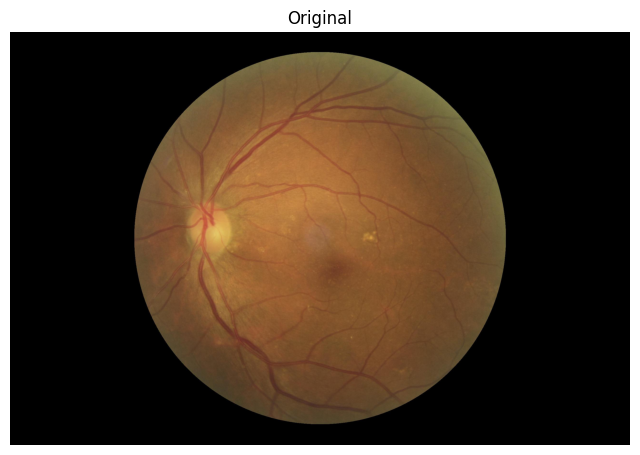

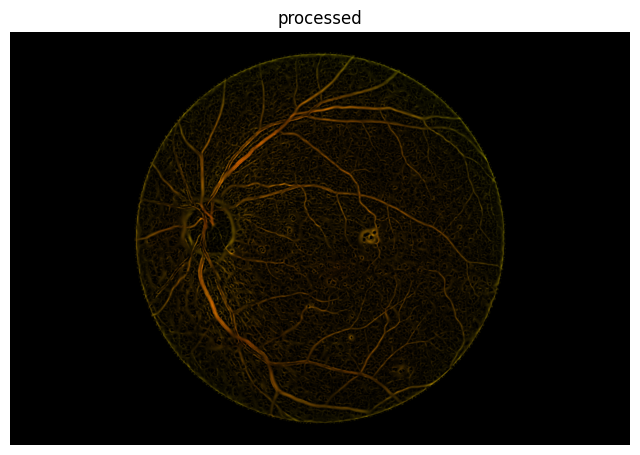

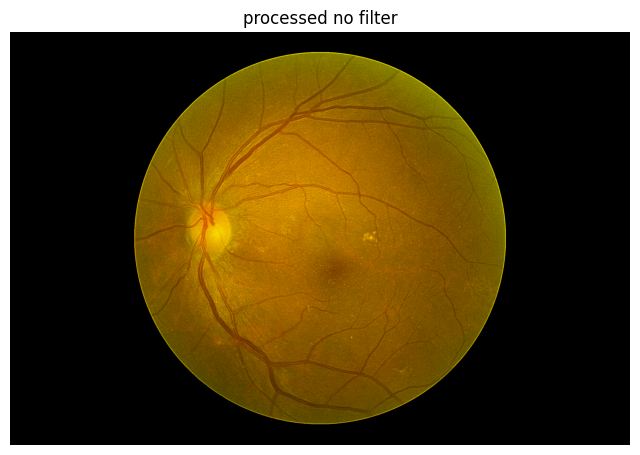

In [13]:

import matplotlib.pyplot as plt
from skimage.io import imread

def plot_image(img, title='', map=None):
  fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
  ax.imshow(img, cmap=map)
  ax.set_title(title)
  ax.axis('off')

# load image here
orig_img = imread(r'/content/drive/MyDrive/ODIR/1015_left.jpg')

print(type(orig_img), orig_img.shape, orig_img.dtype)
plot_image(orig_img, 'Original')

processed = image_process(orig_img)
processed_nofilter = image_process(orig_img, iso_filter=None)

print(type(processed), processed.shape, processed.dtype)
plot_image(processed, 'processed', map='magma')

print(type(processed_nofilter), processed_nofilter.shape, processed_nofilter.dtype)
plot_image(processed_nofilter, 'processed no filter')
